# BAYESIAN COIN TOSS WITH `pymc`

## Imports and Settings

In [1]:
import pymc
import seaborn           as sbn
import matplotlib.pyplot as plt
import numpy             as np

from pymc.Matplot              import plot as mcplot
from scipy.stats.distributions import beta as beta_dist

%matplotlib notebook

## Generate some data

In [2]:
n_samples = 100  # The number of times you toss the coin
true_prob = 0.3  # The probability it comes up heads

data  = pymc.rbernoulli(true_prob, size=n_samples)

## Define your _prior_ belief on the probability $p$ to get heads ...
... in terms of a Beta($\alpha$, $\beta$)-distribution. For example, $\alpha=\beta=1$ specifies a _uniform_ distribution of $p$ over the intervall $[0, 1]$, whereas $\alpha=\beta=\frac{1}{2}$ specifies no prior (Fisher) _information_ on $p$.

In [3]:
alpha = 0.5     # alpha-parameter of the Beta-prior
beta  = 0.5     # beta-parameter of the Beta-prior

prior = pymc.Beta('prob', alpha, beta)

## Define the likelihood
In the case of a coin toss, that would be a Bernoulli-distribution

In [4]:
obs = pymc.Bernoulli('obs', prior, value=data, observed=True)

## Define the `pymc` model

In [5]:
model = pymc.Model([prior, obs])
mcmc  = pymc.MCMC(model)

## Write the Directed Acyclic Graph (DAG) of the model to disk
Works only with the `graphviz` and `pydotplus` packages installed and after changing the line `import pydot` to `import pydotplus as pydot` in the `graph` module of `pymc`.

In [6]:
dag = pymc.graph.dag(model)
dag.write_png('dag.png');

## Sample the _posterior_ distribution of $p$ 

In [7]:
mcmc.sample(100000, burn=1000, thin=10)

 [-----------------100%-----------------] 100000 of 100000 complete in 6.4 sec

## Plot the _posterior_ trace and distribution

Plotting prob


<IPython.core.display.Javascript object>


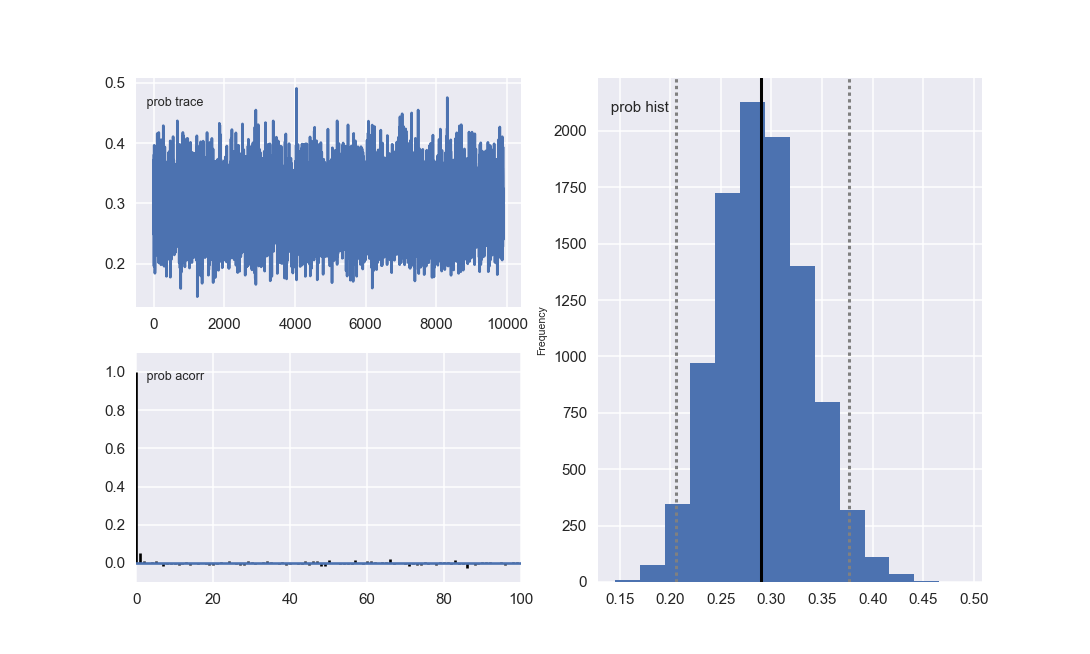

In [8]:
mcplot(mcmc.trace('prob'))

## Fit the _posterior_ and compare to the analytic solution (both Beta-distribution)

<IPython.core.display.Javascript object>


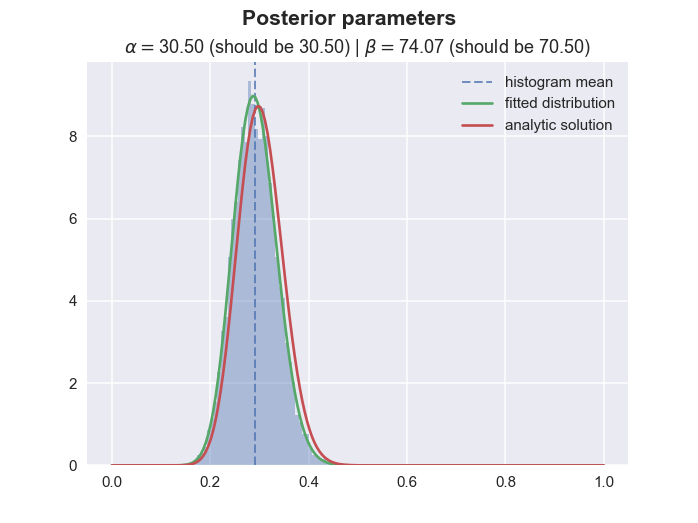

In [9]:
a_true = alpha + n_samples * true_prob
b_true =  beta + n_samples * (1.0 - true_prob)

prob = mcmc.trace('prob')[:]
fit = beta_dist.fit(prob, floc=0, fscale=1)

x = np.linspace(0, 1, 200)
y_fits = beta_dist.pdf(x, fit[0], fit[1])
y_true = beta_dist.pdf(x, a_true, b_true)

fig, ax = plt.subplots(num='Histogram and Fit')
sbn.distplot(prob, kde=False, norm_hist=True, ax=ax)
ax.axvline(prob.mean(), color='#4c72b0', linestyle='dashed', label='histogram mean', linewidth=1.0)
ax.plot(x,y_fits, color='#55a868', label='fitted distribution')
ax.plot(x,y_true, color='#c44e52', label='analytic solution')
fig.suptitle('Posterior parameters', fontsize=14, fontweight='bold')
ax.set_title(  r'$\alpha=$' + '{:.2f}'.format(fit[0]) + 
             ' (should be ' + '{:.2f}'.format(a_true) + ')' + 
             r' | $\beta=$' + '{:.2f}'.format(fit[1]) +
             ' (should be ' + '{:.2f}'.format(b_true) + ')')
ax.legend(loc='best');